In [77]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pandas import DataFrame

In [78]:
data = pd.read_csv("kickstarter_data.csv")
data['success_rate'] = data['pled'] / data['goal'] * 100
data.columns, data.shape

(Index(['Unnamed: 0', 'URL', 'pled', 'goal', 'date', 'period', 'status',
        'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t',
        'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'site',
        'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror',
        'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest',
        'adventure', 'mgp', 'cont', 'curr', 'succsess', 'is_site',
        'success_rate'],
       dtype='object'),
 (8421, 39))

In [79]:
data[data['goal'] < 5]['success_rate'].mean()

331540.3557309402

In [80]:
df = data
if 'Unnamed: 0' in df.columns or 'succsess' in df.columns:
    df = data.drop(columns=['Unnamed: 0', 'succsess'])
df.shape

(8421, 37)

In [81]:
df.isnull().sum()

URL                0
pled               0
goal               0
date               0
period             0
status             0
text_am            0
n_img              0
n_vid              0
n_pled_t           0
min_pled_t         0
max_pled_t         0
mean_pled_t        0
step_pled_t        0
cr_time            0
backed             0
created            0
site            2471
rpg                0
platformer         0
shooter            0
fighting           0
survival           0
horror             0
strategy           0
arcade             0
simulator          0
mmo                0
indie              0
action             0
quest              0
adventure          0
mgp                0
cont               0
curr               0
is_site            0
success_rate       0
dtype: int64

In [172]:
numeric_columns = ['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']
futures = ['text_am', 'n_img', 'n_vid', 'created', 'cont', 'mgp', 'n_pled_t']
target_column = 'success_rate'
numeric_columns, target_column

(['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont'],
 'success_rate')

In [149]:
def draw_boxplots(df, numeric_columns):
    fig, axes = plt.subplots(4, 4, figsize=(18, 40))
    for i in range(2):
        for j in range(4):
            if 4 * i + j == len(numeric_columns):
                return
            axes[i, j].boxplot(df[numeric_columns[4 * i + j]], labels=[numeric_columns[4 * i + j]]) 

In [202]:
def draw_hist(df, features, bar_type=None,names_dict=None):
    bar_type = 'bar' if bar_type == None else bar_type
    rows = 2
    cols = 4
    plt.subplots_adjust(wspace=0.6, hspace=0.3)
    fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
    for i in range(rows):
        for j in range(cols):
            if cols * i + j == len(features):
                return
            
            axes[i, j].hist(df[features[4 * i + j]], histtype=bar_type, bins=10)
            axes[i, j].set_xlabel(f'Значение переменной {features[4 * i + j]}', size=14)
            axes[i, j].set_ylabel(f'Количество проектов с таким {features[4 * i + j]}', size=14)

In [203]:
def draw_hist_2(df, features, bar_type=None,names_dict=None):
    bar_type = 'bar' if bar_type == None else bar_type
    plt.subplots_adjust(wspace=0.6, hspace=0.3)
    rows = 7
    
    for i in range(rows):
        if i == len(features):
            return
        fig = plt.figure(figsize=(10, 8))
        plt.hist(df[features[i]], histtype=bar_type, bins=10)
        fig.xlabel = f'Значение переменной {features[i]}'
        fig.ylabel = f'Количество проектов с таким {features[i]}'

-2.3196048878104314 2.8604102408992116
-7.7375942406523315 27.854264975336246


(8103, 39)

<Figure size 432x288 with 0 Axes>

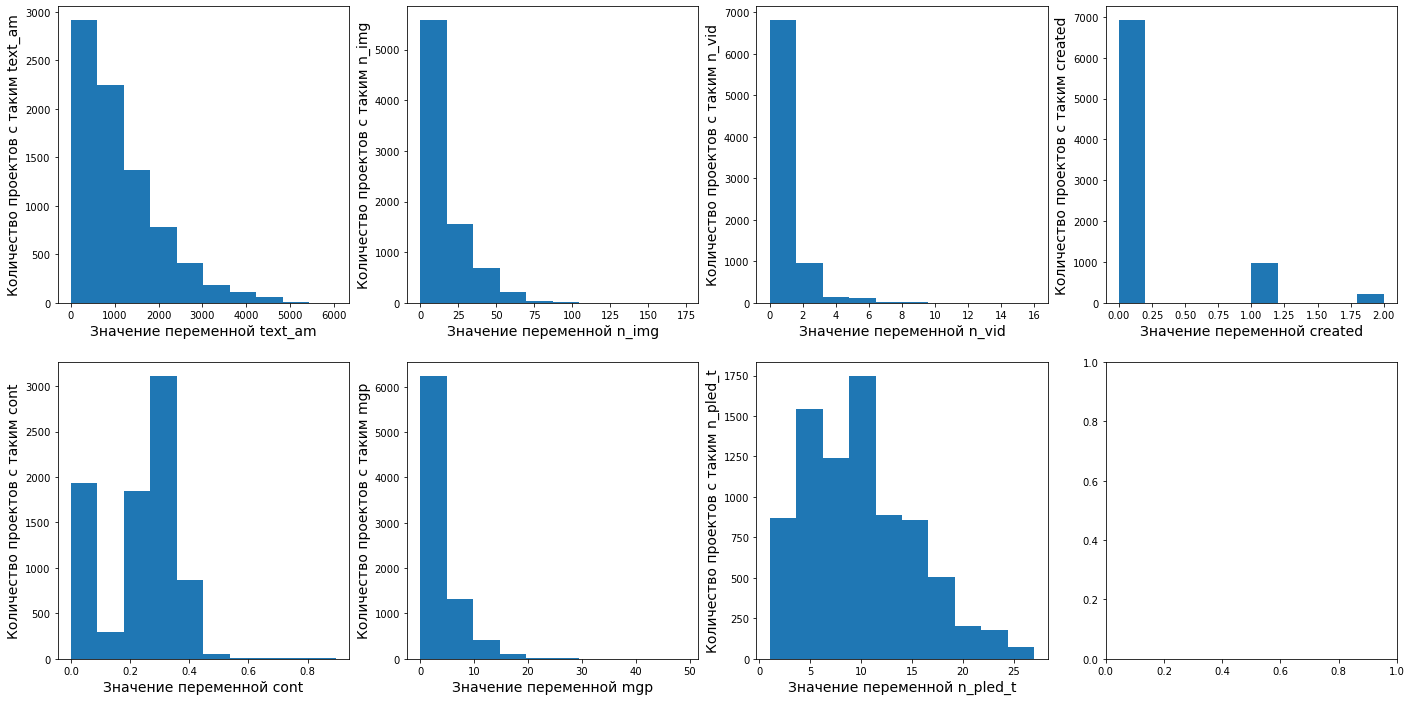

In [207]:
# Remove emissions
df = data
df = df[df['goal'] > 5]
df = df[df['period'] < 80]

df['site'].fillna('', inplace=True)

# Using 3 sigmas rule
n_sigmas = 3

std = df['created'].std() # Taken from description
mean = df['created'].mean()
df = df[(df['created'] >= mean - std * n_sigmas) & (df['created'] <= mean + std * n_sigmas)]
print(mean - std * n_sigmas, mean + std * n_sigmas)

std = df['n_pled_t'].std() # Taken from description
mean = df['n_pled_t'].mean()
print(mean - std * n_sigmas, mean + std * n_sigmas)
df = df[(df['n_pled_t'] >= mean - std * n_sigmas) & (df['n_pled_t'] <= mean + std * n_sigmas)]


draw_hist(df, futures, 'bar')
df.shape

In [87]:
df.isna().sum()

Unnamed: 0      0
URL             0
pled            0
goal            0
date            0
period          0
status          0
text_am         0
n_img           0
n_vid           0
n_pled_t        0
min_pled_t      0
max_pled_t      0
mean_pled_t     0
step_pled_t     0
cr_time         0
backed          0
created         0
site            0
rpg             0
platformer      0
shooter         0
fighting        0
survival        0
horror          0
strategy        0
arcade          0
simulator       0
mmo             0
indie           0
action          0
quest           0
adventure       0
mgp             0
cont            0
curr            0
succsess        0
is_site         0
success_rate    0
dtype: int64

In [88]:
# Descriptive statistics
desc = df[futures].describe()
desc.append(pd.Series(df[futures].median(), index=futures, name='median'))
desc

,text_am,n_img,n_vid,period,cont,mgp,n_pled_t
count,8194.000000,8194.000000,8194.000000,8194.000000,8194.000000,8194.000000,8194.000000
mean,1131.966195,14.340371,0.749695,33.537344,0.224063,3.213599,10.058335
std,915.530566,16.606354,1.336821,10.126667,0.137587,4.057055,5.931977
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,420.000000,1.000000,0.000000,30.000000,0.148704,0.230400,6.000000
50%,883.000000,8.000000,0.000000,30.000000,0.268624,1.766246,9.000000
75%,1592.000000,23.000000,1.000000,33.000000,0.321691,4.681821,13.000000
max,6042.000000,174.000000,16.000000,79.000000,0.894847,49.141376,103.000000


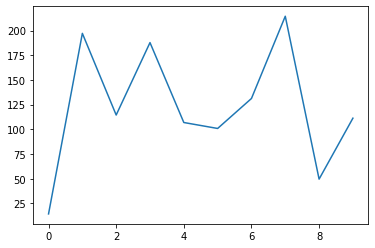

In [99]:
xs = []
ys = []


for vids in sorted(df['n_vid'].unique()):
    mean_sr = df[df['n_vid'] == vids]['success_rate'].mean()
    if df[df['n_vid'] == vids].shape[0] > 5:
        xs.append(vids)
        ys.append(mean_sr)
    
plt.plot(xs, ys) 
plt.xlabel = 'Количество видео'
plt.ylabel = 'Среднее отношения pled / goal'

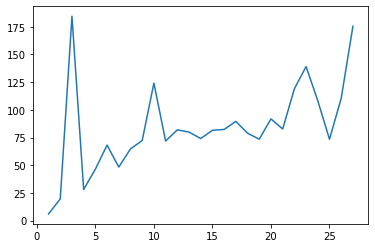

In [208]:
xs = []
ys = []


for vids in sorted(df['n_pled_t'].unique()):
    mean_sr = df[df['n_pled_t'] == vids]['success_rate'].mean()
    if df[df['n_pled_t'] == vids].shape[0] > 7:
        xs.append(vids)
        ys.append(mean_sr)
    
plt.plot(xs, ys) 
plt.xlabel = 'Количество категорий доната'
plt.ylabel = 'Среднее отношения pled / goal'

In [225]:
# Рассчет эксцесса и ассиметрии
for col in futures:

    new_set = df[[col]]
    v = [0] * 10
    mx = max(new_set['n_img'])
    for i in range(len(new_set[col])):
        if i in new_set[col]:
            if int(new_set[col][i] // (mx // 10)) > 9:
                continue
            v[int(new_set[col][i] // (mx // 10))] += 1
    
#     print('x * n')
    xn = []
    for i in range(len(v)):
        xn.append((0.1 + i * 0.2) * v[i])
    xv = sum(xn) / sum(v) # выборочная средняя
#     print(sum(v))
    cm2s = [] # центральный момент 2 порядка
    cm3s = [] # центральный момент 3 порядка
    cm4s = [] # центральный момент 4 порядка
    for i in range(len(v)):
        cm2s.append((0.1 + i * 0.2 - xv) ** 2 * v[i])
        cm3s.append(((0.1 + i * 0.2 - xv) ** 3 * v[i]))
        cm4s.append(((0.1 + i * 0.2 - xv) ** 4 * v[i]))
#     print(sum(cm2s))
#     print(sum(cm3s))
#     print(sum(cm4s))
    disp = new_set[col].var() # выборочная дисперсия
#     print(disp)
    delt = disp ** 0.5 # нормальное отклонение
#     print(delt)
    cm3 = sum(cm3s) / sum(v) 
#     print(cm3)
    cm4 = sum(cm4s) / sum(v) 
#     print(cm4)
    print(f"{col}: ")
    print("A =", str(cm3 / delt ** 3))
    print("E =", str(cm4 / delt ** 4))

text_am: 
A = 7.848168122073097e-11
E = 1.027324355082657e-13
n_img: 
A = 2.106140465521553e-05
E = 1.1289713353608714e-06
n_vid: 
A = 0.040964830177422445
E = 0.02809140862737339
created: 
A = 0.9288554773712707
E = 1.8720700040886735
cont: 
A = -0.04904911383189113
E = 1.0494335946480908
mgp: 
A = 0.003065610693193213
E = 0.001270277809131886
n_pled_t: 
A = 0.0
E = 0.0


In [221]:
# Linear models
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np

In [53]:
numeric_columns = [
#   'pled',
  'goal',
#   'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']
columns = numeric_columns + binary_columns

In [100]:
def test_mse(model, X, y):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    
    return mse

In [101]:
train_X, test_X, train_y, test_y = train_test_split(df[columns], df[target_column], train_size=0.8)

In [102]:
scaler = StandardScaler()

train_data = scaler.fit_transform(train_X)
test_x_data = scaler.transform(test_X)
test_y_data = test_y

In [103]:
# Simple Linear Regression
model = LinearRegression()
model.fit(train_data, train_y)

test_mse(model, train_data, train_y), test_mse(model, test_x_data, test_y_data), model.coef_

(371721.6529566447,
 1860161.9860698434,
 array([ -5.74012332,  -4.7159362 , -36.44766104,  33.23114505,
         -8.39274422,   7.63879727,  -1.75575513, -22.96014958,
         13.79243405,  19.12413078,   0.38128728,   8.23033738,
         54.89605256,   9.6221342 ,  21.91944892,  24.50257488,
         -1.86547011,  -9.02226754, -11.46711642,  19.84944581,
         -5.27562449,   2.37126817,  13.80306482,  -2.93825946,
         -0.89877999,  -8.56170218,  16.07596588,   7.88923264,
         11.93290456]))

In [104]:
# Testing regression /w L1 regularization
lasso = Lasso()
lasso.fit(train_data, train_y)

test_mse(lasso, train_data, train_y), test_mse(lasso, test_x_data, test_y_data), lasso.coef_

(371777.4121988419,
 1859695.6052475332,
 array([ -5.34163745,  -4.1670915 , -28.39681835,  32.30655044,
         -8.25159358,   3.55609035,  -2.94218731, -13.2208398 ,
          5.94355246,  18.78593329,   0.        ,   7.76020812,
         46.8275335 ,   8.2736885 ,  20.46064784,  23.45835672,
         -1.23695682,  -8.2814898 , -10.61275451,  18.51337128,
         -4.84374565,   0.9098175 ,  12.56889488,  -2.25937694,
         -0.        ,  -7.80795162,  14.95695369,   6.90529121,
         10.61589044]))

In [105]:
# Testing regression /w L2 regularization
ridge = Ridge()
ridge.fit(train_data, train_y)

test_mse(ridge, train_data, train_y), test_mse(ridge, test_x_data, test_y_data), ridge.coef_

(371721.65406636964,
 1860159.354592906,
 array([ -5.73998864,  -4.72010777, -36.38832265,  33.2271543 ,
         -8.39031086,   7.62471226,  -1.77523341, -22.91695926,
         13.77110992,  19.12203788,   0.38164243,   8.23035503,
         54.84019337,   9.62044969,  21.91520492,  24.49788953,
         -1.8662178 ,  -9.0215424 , -11.46513944,  19.84589472,
         -5.27531488,   2.3699608 ,  13.8007962 ,  -2.93763078,
         -0.89951327,  -8.56094741,  16.07345319,   7.88759158,
         11.9311213 ]))

In [106]:
elastic = ElasticNet()
elastic.fit(train_data, train_y)

test_mse(elastic, train_data, train_y), test_mse(elastic, test_x_data, test_y_data), elastic.coef_

(372657.1273233606,
 1859003.853406725,
 array([-4.30381049e+00, -1.54116961e+00, -5.47978045e-01,  2.20814440e+01,
        -2.85288466e+00,  8.29517136e-01, -4.10847615e+00, -5.21201635e+00,
         3.69935214e-01,  1.35930037e+01,  1.64345240e+00,  7.36276090e+00,
         1.62768905e+01,  6.94658158e+00,  1.33170773e+01,  1.57063716e+01,
        -2.10224988e+00, -5.63785168e+00, -6.99584716e+00,  1.23792723e+01,
        -4.54044020e+00,  1.76409052e-01,  8.48878533e+00, -2.04416460e+00,
         6.22309120e-03, -5.26193931e+00,  1.08182891e+01,  5.98534750e+00,
         7.80109879e+00]))

In [107]:
# Get mean coeffs for futures
coeffs = np.zeros((29))
rounds = 20
for i in range(20):
    scaler = StandardScaler()

    train_data = scaler.fit_transform(train_X)
    test_x_data = scaler.transform(test_X)
    test_y_data = test_y
    
    model = LinearRegression()
    model.fit(train_data, train_y)
    coeffs += model.coef_
    
    lasso = Lasso()
    lasso.fit(train_data, train_y)
    coeffs += lasso.coef_
    
    ridge = Ridge()
    ridge.fit(train_data, train_y)
    coeffs += ridge.coef_
    
    elastic = ElasticNet()
    elastic.fit(train_data, train_y)
    coeffs += elastic.coef_
    
mean_coeffs = coeffs / (rounds * 4)
{k: v for k, v in sorted([(k, v) for k, v in zip(columns, mean_coeffs)], key=lambda x: abs(x[1]), reverse=True)}

{'mgp': 43.21016749329429,
 'n_vid': 30.211573436584086,
 'n_img': -25.445195021563677,
 'platformer': 22.04129818510761,
 'rpg': 19.403094736946187,
 'cr_time': 17.656276413966733,
 'horror': 17.64699602437806,
 'mean_pled_t': -16.077491247398832,
 'quest': 14.481165474528897,
 'simulator': 12.165385307913473,
 'is_site': 10.570253770493364,
 'survival': -10.135214381917498,
 'cont': 8.615713493951546,
 'step_pled_t': 8.46925791101513,
 'fighting': -7.990787853218,
 'created': 7.895915356836417,
 'action': -7.548135130328255,
 'adventure': 7.166865734111838,
 'n_pled_t': -6.971883328655738,
 'goal': -5.281389974928035,
 'strategy': -4.98378130167586,
 'min_pled_t': 4.912279255243652,
 'text_am': -3.7860762690541163,
 'max_pled_t': -2.645413000993173,
 'mmo': -2.544857943322742,
 'shooter': -1.7677236520100728,
 'arcade': 1.456863881270807,
 'backed': 0.6015955276514187,
 'indie': -0.448017543375672}

In [108]:
# Neural network
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [109]:
def get_type(rate):
    type_ = 0
    for i in np.linspace(0, 175, 8):
        if rate < i + 25:
            return type_
        type_ += 1
    return 8

In [110]:
# Add success type

types = []

for idx, row in df.iterrows():
    types.append(get_type(row[-1]))

types = pd.Series(types, dtype=int)
df = df.assign(succes_type=types.values)
if 'success_rate' in df.columns:
    df = df.drop(columns='success_rate')
if 'success' in df.columns:
    df = df.drop(columns='success')

In [111]:
df.columns

Index(['Unnamed: 0', 'URL', 'pled', 'goal', 'date', 'period', 'status',
       'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t',
       'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'site',
       'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror',
       'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest',
       'adventure', 'mgp', 'cont', 'curr', 'succsess', 'is_site',
       'succes_type'],
      dtype='object')

In [112]:
numeric_columns = [
#   'pled',
  'goal',
#   'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']

numeric_data = numeric_columns + binary_columns
target_col = df.corr().columns[-1]

print(numeric_data, target_col)

dataset = df[numeric_data]
target = df[target_col]

['goal', 'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t', 'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'mgp', 'cont', 'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror', 'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest', 'adventure', 'is_site'] succes_type


In [113]:
model = nn.Sequential(
    nn.BatchNorm1d(28),
    nn.Linear(28, 24),
    nn.ReLU(),
    nn.BatchNorm1d(24),
    nn.Linear(24, 20),
    nn.ReLU(),
    nn.BatchNorm1d(20),
    nn.Linear(20, 10))

optimizer = Adam(model.parameters())
loss_fn = F.cross_entropy

In [114]:
class MyDataset:
    def __init__(self, df):
        self.df = pd.DataFrame(data=df)
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        return torch.Tensor(self.df.iloc[i])[:-1], torch.Tensor(self.df.iloc[i])[-1].to(torch.long)

In [115]:
from torch.utils.data import DataLoader


train, test = train_test_split(dataset, train_size=0.8)

train_loader = DataLoader(MyDataset(train), batch_size=24, shuffle=True)
test_loader = DataLoader(MyDataset(test), batch_size=24)

In [116]:
model.train()

losses = []
accuracies = []

for epochs in tqdm(range(10)):
    epoch_losses = []
    epoch_accuracies = []
    for xb, yb in tqdm(train_loader):
        accuracy = 0
        correct_answers = 0
        
        optimizer.zero_grad()

        outp = model(xb)
        loss = loss_fn(outp, yb)

        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        
        correct_answers = (outp.argmax(-1) == yb).sum()
        accuracy = correct_answers / xb.shape[0]
        epoch_accuracies.append(accuracy)
    
    losses.append(torch.tensor(epoch_losses).mean())
    accuracies.append(torch.tensor(epoch_accuracies).mean())
    
    print('loss:', losses[-1])
    print('accuracy: ', accuracies[-1])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(1.6762)
accuracy:  tensor(0.5838)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.6663)
accuracy:  tensor(0.7335)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5518)
accuracy:  tensor(0.7382)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5276)
accuracy:  tensor(0.7454)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5235)
accuracy:  tensor(0.7435)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5132)
accuracy:  tensor(0.7483)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5141)
accuracy:  tensor(0.7443)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5114)
accuracy:  tensor(0.7477)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5124)
accuracy:  tensor(0.7457)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5145)
accuracy:  tensor(0.7485)


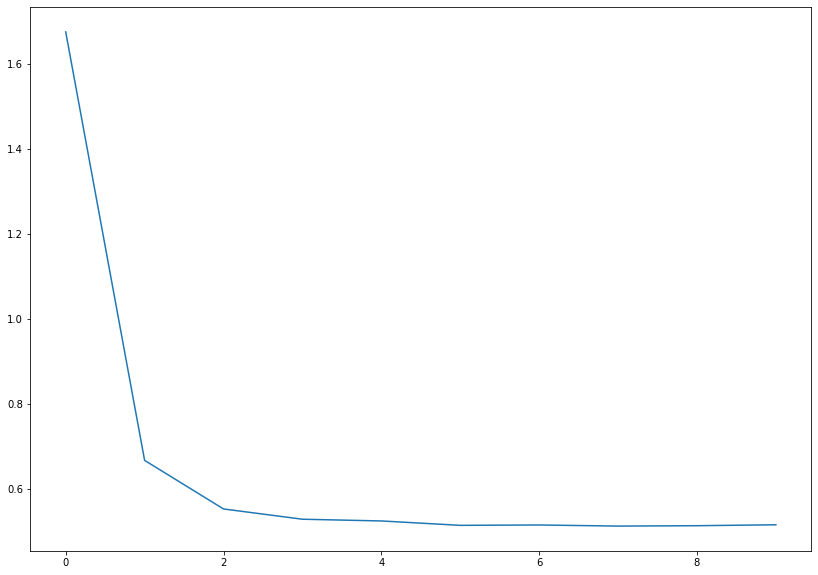

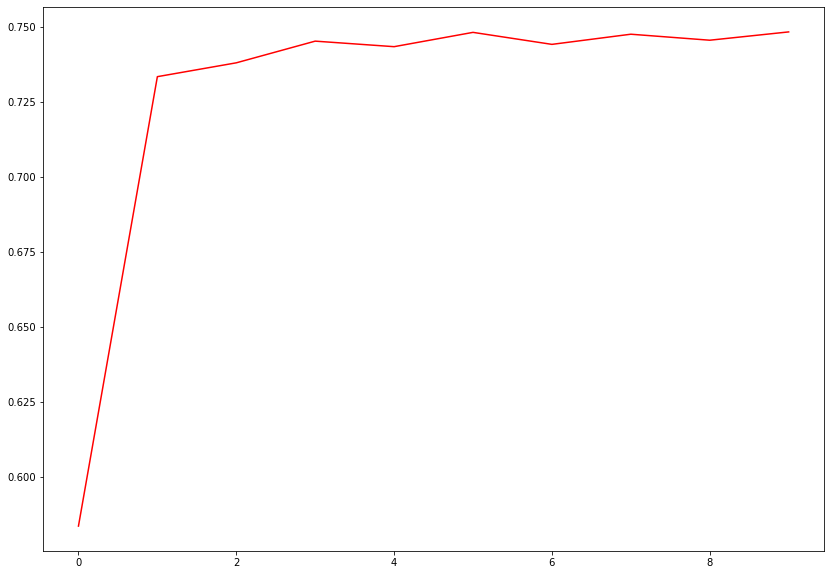

In [117]:
plt.figure(figsize=(14, 10))
plt.plot(range(epochs + 1), losses, label='loss')

plt.figure(figsize=(14, 10))
plt.plot(range(epochs + 1), accuracies, label='accuracy', c='r')

In [118]:
model.eval()

losses = []
accuracies = []

for xb, yb in test_loader:
    with torch.no_grad():
        outp = model(xb)
        correct_answers = (outp.argmax(-1) == yb).sum()
        accuracy = correct_answers / xb.shape[0]
        accuracies.append(accuracy)
torch.Tensor(accuracies).mean()

tensor(0.7341)

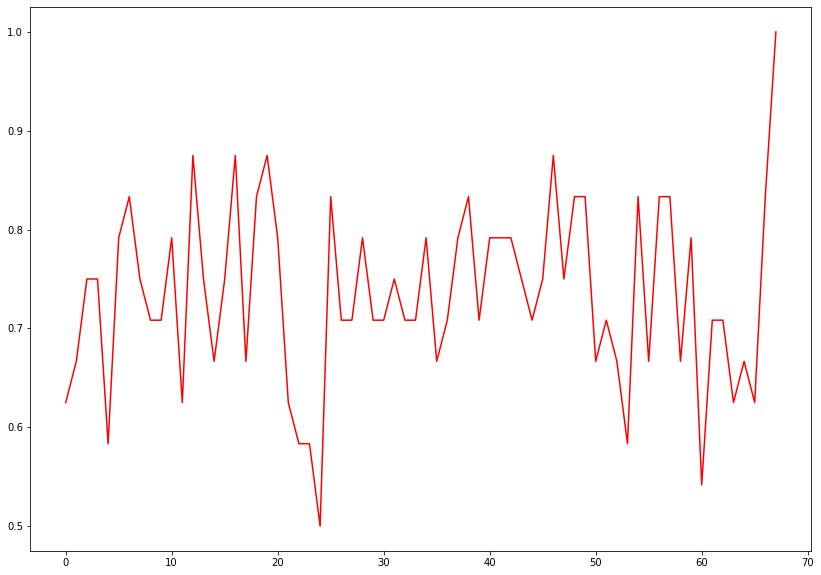

In [119]:
plt.figure(figsize=(14, 10))
plt.plot(np.arange(len(test_loader)), accuracies, label='accuracy', c='r')